In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# 讀取 Muist 數字手寫資料 pickle
with open('mnist.pickle', 'rb') as file:
    (x_train, t_train), (x_test, t_test) = pickle.load(file)  

from PIL import Image
    
def img_show(img):
    img = -(img-1)
    
    return Image.fromarray(np.uint8(img*255))

def trans(arr):
    num = int(arr.shape[0]**0.5)
    arr = arr.reshape(num, num, 28, 28).transpose(0, 2, 1, 3).reshape(num*28, num*28)
    
    return arr

def create_layer(inputs, in_size, out_size, n_layer, activation_function=None):
    layer_name = 'layer' + n_layer
    # W & b 初始化條件 init
    W_init = tf.random_normal_initializer(stddev=(1/in_size)**0.5, seed=59)
    b_init = tf.random_normal_initializer(stddev=(1/in_size)**0.5, seed=59)
    # W & b 變數設定
    Weights = tf.get_variable(name=layer_name+'_W', shape=[in_size, out_size], initializer=W_init)
    #tf.summary.histogram('weights', Weights) # 紀錄資料
    biases = tf.get_variable(name=layer_name+'_b', shape=[out_size], initializer=b_init)
    #tf.summary.histogram('biases', biases) # 紀錄資料
    Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
    #Wx_plus_b = tf.matmul(inputs, Weights)
    # 激活函數設定
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    #tf.summary.histogram('outputs', outputs)
    
    return outputs

In [2]:
dim = 2
with tf.name_scope('inputs'):
    inputs = tf.placeholder(tf.float32, [None, 784], name='x_input')
    codes = tf.placeholder(tf.float32, shape=[None, dim])
    
with tf.variable_scope('encoder1'):
    encoder1 = create_layer(inputs, 784, 480, n_layer='en1', activation_function=tf.nn.relu)

with tf.variable_scope('encoder2'):
    encoder2 = create_layer(encoder1, 480, 120, n_layer='en2', activation_function=tf.nn.relu)
    
with tf.variable_scope('encoder3'):
    encoder3 = create_layer(encoder2, 120, 30, n_layer='en3', activation_function=tf.nn.relu)
    
with tf.variable_scope('encoder4'):
    encoder4 = create_layer(encoder3, 30, dim, n_layer='en4', activation_function=tf.nn.relu)
    cod = tf.concat([encoder4, codes], axis=0)

with tf.variable_scope('decoder1'):
    decoder1 = create_layer(cod, dim, 30, n_layer='de1', activation_function=tf.nn.relu)

with tf.variable_scope('decoder2'):
    decoder2 = create_layer(decoder1, 30, 120, n_layer='de2', activation_function=tf.nn.relu)
    
with tf.variable_scope('decoder3'):
    decoder3 = create_layer(decoder2, 120, 480, n_layer='de3', activation_function=tf.nn.relu)
    
with tf.variable_scope('decoder4'):
    decoder4 = create_layer(decoder3, 480, 784, n_layer='de4', activation_function=tf.nn.relu)
    
with tf.name_scope('outputs'):    
    outputs = decoder4 / tf.reduce_max(decoder4, axis=1)[:, tf.newaxis]

# cross entropy
with tf.name_scope('loss'):
    # 輸入為 batch 使用平均值 mean + L2正則化
    loss = tf.reduce_mean(tf.reduce_sum(tf.pow((outputs - inputs), 2)/2, axis=1)) \
    + 0.005 * tf.reduce_mean(tf.reduce_sum(tf.pow(encoder4, 2), axis=1)) # L2正則化
    #tf.summary.scalar('loss', loss) # 紀錄資料

# train_way = tf.train.MomentumOptimizer(learning_rate=0.0005, momentum=0.9) # loss_min:14.9
train_way = tf.train.AdamOptimizer() # loss_min:13.6

with tf.name_scope('train'):
    train_step = train_way.minimize(loss)

sess = tf.Session()
#merged = tf.summary.merge_all() # 所以紀錄資料設定
#writer = tf.summary.FileWriter("logs/", sess.graph) # 紀錄圖形
sess.run(tf.global_variables_initializer()) # 變數初始化
i_ = 1

In [3]:
data_num = x_train.shape[0]
batch = 100
lst = np.arange(data_num)
# train epoch
for ii in range(33):
    # 隨機打亂資料排序
    np.random.shuffle(lst)
    x_train = x_train[lst]
    t_train = t_train[lst]
    # train 
    for i in range(0, data_num, batch):  # 每 bench 100個資料
        feed_data = {inputs: x_train[i:i + batch], codes:np.zeros([0, dim])}
        sess.run(train_step, feed_dict=feed_data)
        
    #result = sess.run(merged, feed_dict=feed_data) # 寫入紀錄
    #writer.add_summary(result, i_)
    
    los = sess.run(loss, feed_dict={inputs:x_train, codes:np.zeros([0, dim])})
    print('%3d  loss:%.4f'%(i_, los))
    i_ += 1
    
# in win10 open powershell key:  tensorboard --logdir="logs" 

  1  loss:22.6779
  2  loss:19.6131
  3  loss:18.7642
  4  loss:18.0120
  5  loss:17.6369
  6  loss:17.1851
  7  loss:16.8421
  8  loss:16.6164
  9  loss:16.5117
 10  loss:16.4694
 11  loss:16.1990
 12  loss:16.3639
 13  loss:15.9316
 14  loss:15.9834
 15  loss:15.7788
 16  loss:15.6071
 17  loss:15.4389
 18  loss:15.4023
 19  loss:15.2639
 20  loss:15.2629
 21  loss:15.2152
 22  loss:15.1330
 23  loss:15.1687
 24  loss:15.2040
 25  loss:15.0883
 26  loss:15.1463
 27  loss:15.1343
 28  loss:15.1818
 29  loss:14.9881
 30  loss:15.0078
 31  loss:14.9425
 32  loss:14.8747
 33  loss:14.9785


### inputs outputs 比較

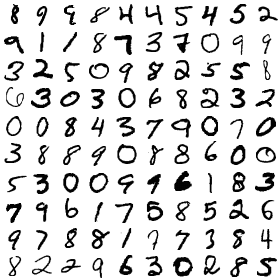

In [4]:
img_show(trans(x_train[0:100]))

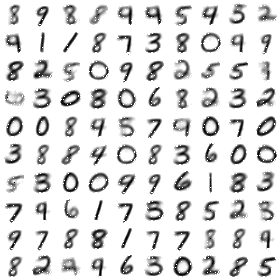

In [5]:
op = sess.run(outputs, feed_dict={inputs: x_train[0:100], codes:np.zeros([0, dim])})
img_show(trans(op))

### 數字分布(二維)

(0, 2)

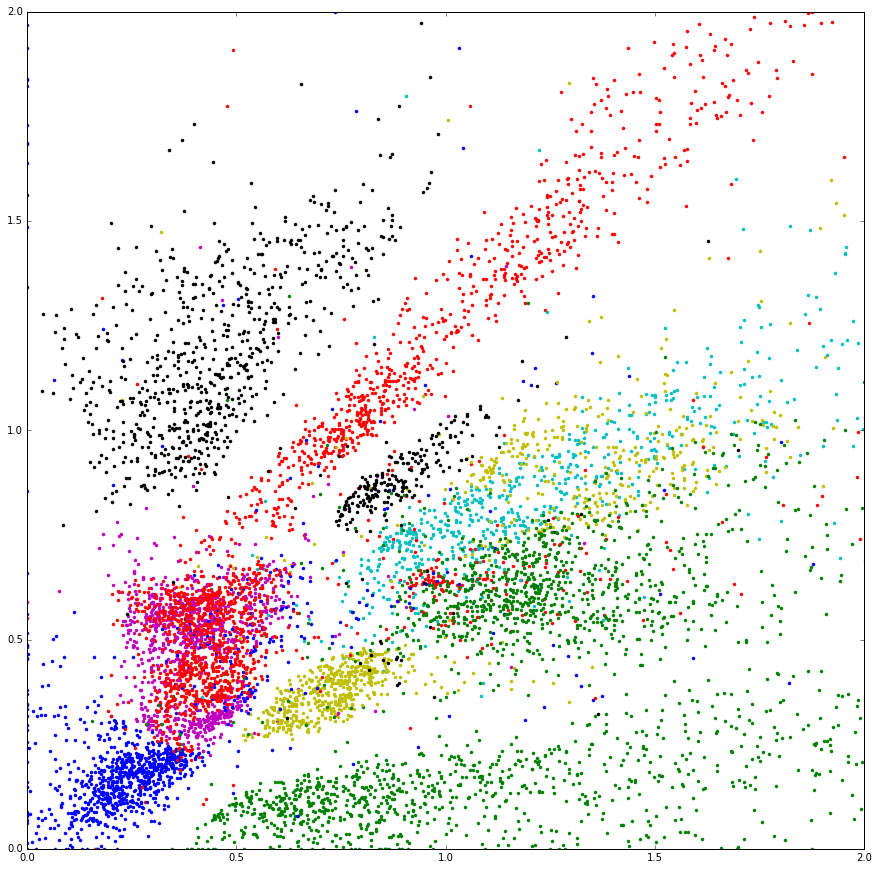

In [6]:
ar0 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 0], codes:np.zeros([0, dim])})
ar1 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 1], codes:np.zeros([0, dim])})
ar2 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 2], codes:np.zeros([0, dim])})
ar3 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 3], codes:np.zeros([0, dim])})
ar4 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 4], codes:np.zeros([0, dim])})
ar5 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 5], codes:np.zeros([0, dim])})
ar6 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 6], codes:np.zeros([0, dim])})
ar7 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 7], codes:np.zeros([0, dim])})
ar8 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 8], codes:np.zeros([0, dim])})
ar9 = sess.run(encoder4, feed_dict={inputs: x_test[t_test.argmax(axis=1) == 9], codes:np.zeros([0, dim])})

fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(ar0[:, 0], ar0[:, 1], '.')
ax.plot(ar1[:, 0], ar1[:, 1], '.')
ax.plot(ar2[:, 0], ar2[:, 1], '.')
ax.plot(ar3[:, 0], ar3[:, 1], '.')
ax.plot(ar4[:, 0], ar4[:, 1], '.')
ax.plot(ar5[:, 0], ar5[:, 1], '.')
ax.plot(ar6[:, 0], ar6[:, 1], '.')
ax.plot(ar7[:, 0], ar7[:, 1], '.')
ax.plot(ar8[:, 0], ar8[:, 1], '.')
ax.plot(ar9[:, 0], ar9[:, 1], '.')
plt.xlim(0, 2)
plt.ylim(0, 2)

### 產生數字decoder

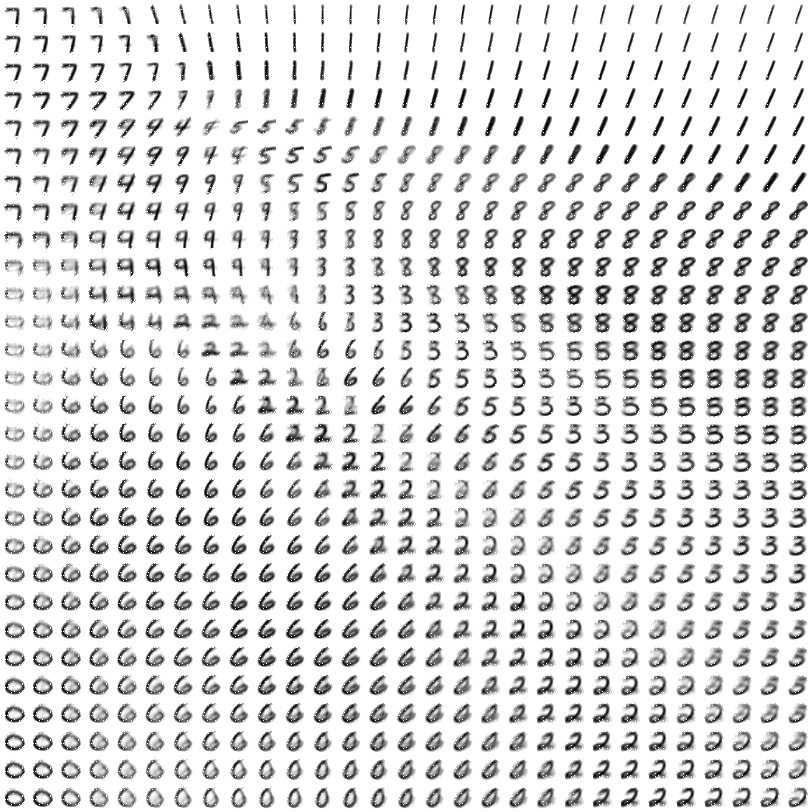

In [7]:
ax = np.linspace(0, 2, 29)
ax1, ax2 = np.meshgrid(ax, ax)
arr = np.vstack((ax1.flatten(), ax2.flatten())).T
codtrans = sess.run(outputs, feed_dict={inputs:np.zeros([0, 784]), codes:arr})
img_show(trans(codtrans))